# Classes detections

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import time
import random
# Import PyTorch modules (edit this list if needed)
import torch
print(f'PyTorch version: {torch.__version__}')
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from matplotlib import image as mpimg

PyTorch version: 2.1.0+cu121


### Selecting the device on which the notebook will be running

In [2]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")

### Defining global variables

In [3]:
WIDTH, HEIGHT = 28, 28
EPOCHS: int = 20
BATCH_SIZE: int = 32
LEARNING_RATE = 0.01

### Defining classes and printing on random element from each class

In [4]:
resources_folder = 'resources/classification/'

classes = ['apple', 'golf club', 'hedgehog', 'moon', 'mushroom', 'rain', 'roller coaster', 'squirrel']
nb_classes = len(classes)

data = [np.load(os.path.join(resources_folder, 'full_numpy_bitmap_'+class_name+'.npy')) for class_name in classes]
print(f'loaded numpy bitmaps, {nb_classes} classes')

loaded numpy bitmaps, 8 classes


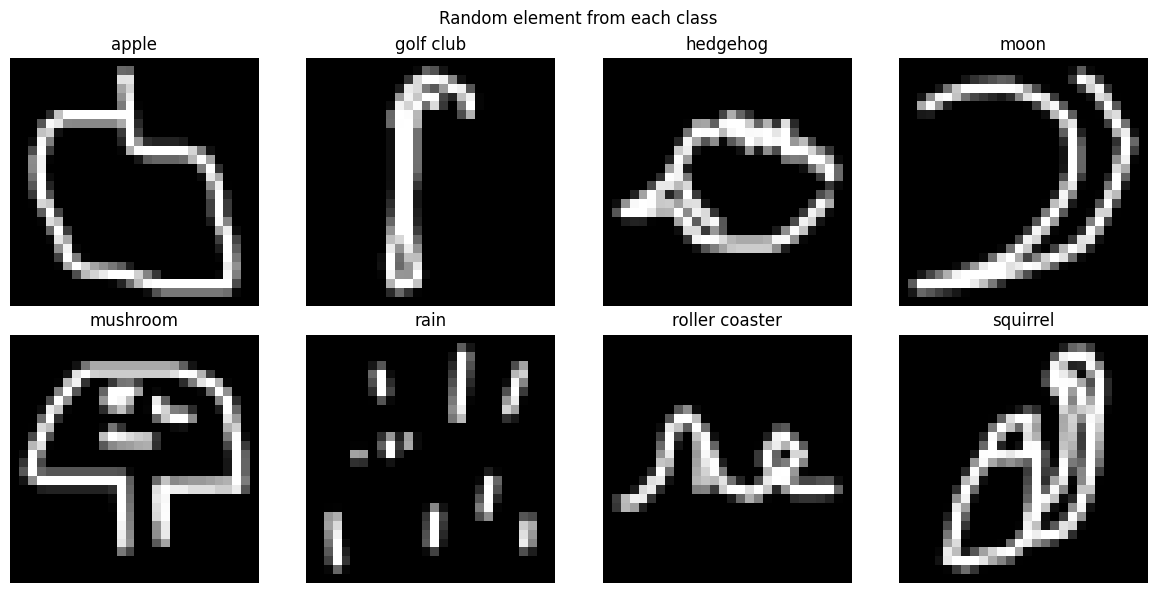

In [5]:
to_plot = []

for class_data in data:
    array = random.choice(class_data).reshape(WIDTH, HEIGHT)
    to_plot.append(array)

num_cols = 4
num_rows = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

for i in range(nb_classes):
    row_index = i // num_cols
    col_index = i % num_cols
    axes[row_index, col_index].imshow(to_plot[i], cmap='gray')
    axes[row_index, col_index].axis('off')
    axes[row_index, col_index].set_title(classes[i])

plt.tight_layout()
plt.suptitle('Random element from each class')

plt.subplots_adjust(top=0.9)

plt.show()

### Dataset creation

In [6]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        super().__init__()

        self.size = ""

        self.data=np.array(data)
        self.labels=np.array(labels)

        self.reshaped_data = [self.reshape_image(img) for img in data]

    def reshape_image(self, img):
        return img.reshape(WIDTH, HEIGHT)
        

    def __getitem__(self, key: int):
        assert key < self.__len__()

        img = self.reshaped_data[key]
        label = self.labels[key]

        return img, label

    
    def __len__(self):
        return len(self.reshaped_data)

In [7]:
split = 0.8

training_data, validation_data = [], []
training_labels, validation_labels = [], []

for class_data, label in zip(data, np.arange(start=0, stop=8)):
    np.random.shuffle(class_data)

    split_idx=int(split*len(class_data))
    
    for img in class_data[:split_idx]:
        training_data.append(img.astype(np.float32))
        training_labels.append(label)

    for img in class_data[split_idx:]:
        validation_data.append(img.astype(np.float32))
        validation_labels.append(label)

assert len(training_data) == len(training_labels)
assert len(validation_data) == len(validation_labels)

print(f'training dataset size : {len(training_data)}')
print(f'validation dataset size : {len(validation_data)}')

training dataset size : 927239
validation dataset size : 231814


In [8]:
training_combined_lists = list(zip(training_data, training_labels))

training_permutation = list(range(len(training_combined_lists)))
random.shuffle(training_permutation)

shuffled_training_lists = [training_combined_lists[i] for i in training_permutation]
shuffled_training_data, shuffled_training_labels = zip(*shuffled_training_lists)

################################################################################

validation_combined_lists = list(zip(training_data, training_labels))

validation_permutation = list(range(len(validation_combined_lists)))
random.shuffle(validation_permutation)

shuffled_validation_lists = [training_combined_lists[i] for i in validation_permutation]
shuffled_validation_data, shuffled_validation_labels = zip(*shuffled_validation_lists)

In [9]:
len_subset = 40000

training_set = CustomDataset(data=shuffled_training_data[:len_subset], labels=shuffled_training_labels[:len_subset])
validation_set = CustomDataset(data=shuffled_validation_data[:len_subset], labels=shuffled_validation_labels[:len_subset])

training_loaded_set = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
validation_loaded_set = DataLoader(validation_set, batch_size=BATCH_SIZE , shuffle=True)

### Model implementation

In [10]:
# YOUR CODE HERE

class Net(nn.Module):
    def __init__(self, width: int, device):
        nn.Module.__init__(self)

        self._device = device

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)

        self.pool = nn.MaxPool2d(2, 2)

        shape_after_conv = int((((((width-4)/2)-2)/2)-2)/2)

        self.fc1 = nn.Linear(128 * shape_after_conv * shape_after_conv, 64)
        self.fc2 = nn.Linear(64, 8)

        self.dropout1 = nn.Dropout(p=0.2)
        self.dropout2 = nn.Dropout(p=0.5)

        self.bn = nn.BatchNorm2d(num_features=32)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = self.bn(x)
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.softmax(x)
        return x
    
    def fit(self, train_loader, valid_loader, nb_epochs:int =10, learning_rate=0.01):
        self.loss_history = []
        self.train_acc_history = []
        self.valid_acc_history = []

        self.nb_epochs = [epoch+1 for epoch in range(nb_epochs)]

        import torch.optim as optim
        
        optimizer = optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)

        criterion = nn.CrossEntropyLoss()

        start_time = time.time()

        for epoch in self.nb_epochs:

            running_loss = 0.0
            nb_batch = 0

            for i, data in enumerate(train_loader, start=0):
                nb_batch+=1
                inputs, labels = data
                inputs, labels = inputs.to(self._device), labels.to(self._device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.forward(inputs)

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                
            running_loss/=nb_batch
            train_acc = self.compute_accuracy(train_loader)*100
            valid_acc = self.compute_accuracy(valid_loader)*100
            
            print(f'epoch [{epoch}/{len(self.nb_epochs)}], loss : {running_loss}, train acc : {round(train_acc,3)}%, valid acc : {round(valid_acc,3)}%')
            self.loss_history.append(running_loss)
            self.train_acc_history.append(train_acc)
            self.valid_acc_history.append(valid_acc)
                    
        print('Finished Training')

        end_time = time.time()
        self.training_time = end_time - start_time

    def compute_accuracy(self, dataset: DataLoader):
        correct, total = 0, 0

        for data in dataset:
            inputs, labels = data
            inputs, labels = inputs.to(self._device), labels.to(self._device)

            outputs = self.forward(inputs)
            _, predicted_classes = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted_classes == labels).sum().item()

        return correct/total

### Modle training

In [11]:
model = Net(width=WIDTH, device=device)
model.to(device)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
print(f'number of trainable parameters : {sum([np.prod(p.size()) for p in model_parameters])}')

model.fit(training_loaded_set, validation_loaded_set)

number of trainable parameters : 138440
epoch [1/10], loss : 1.7898247321128846, train acc : 63.15%, valid acc : 63.225%
epoch [2/10], loss : 1.574246471118927, train acc : 74.015%, valid acc : 74.267%
epoch [3/10], loss : 1.5260812125205994, train acc : 76.935%, valid acc : 76.78%
epoch [4/10], loss : 1.448878420162201, train acc : 81.57%, valid acc : 81.147%
epoch [5/10], loss : 1.421657247543335, train acc : 84.898%, valid acc : 84.707%
epoch [6/10], loss : 1.417325807762146, train acc : 86.12%, valid acc : 85.575%
epoch [7/10], loss : 1.4044974939346313, train acc : 87.535%, valid acc : 87.382%
epoch [8/10], loss : 1.404278512954712, train acc : 87.685%, valid acc : 87.39%
epoch [9/10], loss : 1.411087922000885, train acc : 86.323%, valid acc : 85.987%
epoch [10/10], loss : 1.4049686636924743, train acc : 86.728%, valid acc : 86.308%
Finished Training


### Plotting metrics

In [12]:
def plot_loss_and_accuracy_per_epoch(model):
    plt.plot(model.nb_epochs, model.loss_history)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('loss per epoch')
    plt.show()

    plt.plot(model.nb_epochs, model.train_acc_history, label='training')
    plt.plot(model.nb_epochs, model.valid_acc_history, label='validation')
    plt.ylabel('accuracy in %')
    plt.xlabel('epoch')
    plt.ylim(0, 100)
    plt.title('accuracy per epoch')
    plt.legend()
    plt.show()

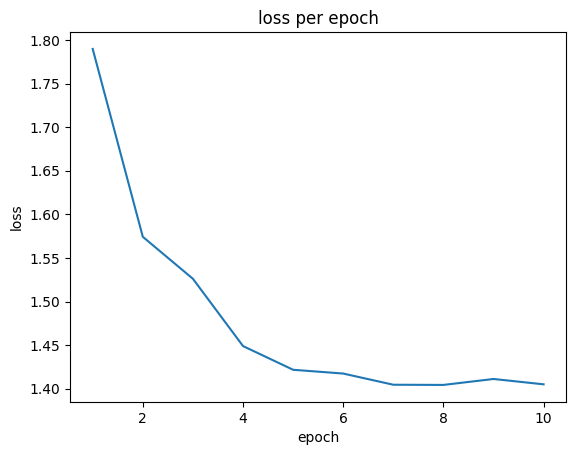

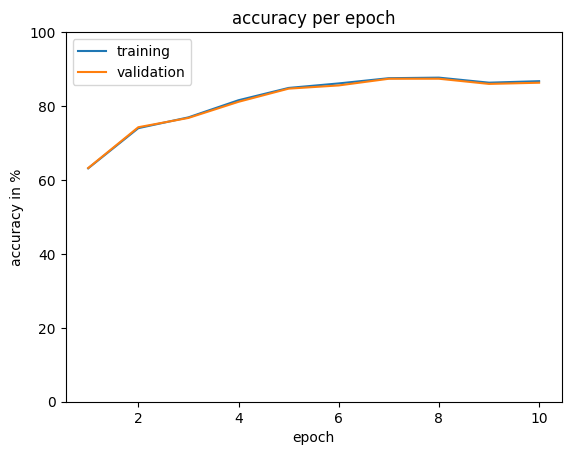

training accuracy : 86.765 %
validaiton accuracy : 86.26 %


In [13]:
plot_loss_and_accuracy_per_epoch(model)

print(f'training accuracy : {model.compute_accuracy(training_loaded_set)*100} %')
print(f'validaiton accuracy : {model.compute_accuracy(validation_loaded_set)*100} %')